# Asteroseismology Data Science Task: KIC4448777

## Aufgabenstellung

- Kallinger Data: https://ucloud.univie.ac.at/index.php/s/7xy0dezG0Oo70Sg
- Houdek Data: https://homepage.univie.ac.at/guenter.houdek/ss20/

Purpose of this work is the Anlysis of observational Data on the Red Giant KIC 4448777 in serveral steps.

## Group participants

- Robert David Ancyzk 11703356
- Dennis Hofbauer 01616688
- Matthias Stallovits 11703206
- Patrick Fodor 00747925

### Data Processing
- remove ‘inf’ values
- remove 4σ outliers
- divide by 5d-running average
- stitch together

### Fourier Transformation
- aplitude spectrum
- spectral window

### Spectral Analysis
- Lorentzian fit

### Mesa simulation and Gyre evaluation
- Install from git with as described in: https://github.com/evbauer/MESA-Docker
- execute MESA scripts with given information about the star
- generate Echelle diagrams with GYRE data

Goal is to compare the simulated GYRE data and echelle diagrams witht eh measured echelle diagrams.

## Import aller benötigten Python Abhängigkeiten

In [1]:
import math
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# import seaborn as sns
# plt.style.use('ggplot')
# sns.set_style("whitegrid", {'axes.grid' : False})
# matplotlib.rc('animation', html='html5')
FIGSIZE = (16, 6)

# output all statements
from IPython.core.interactiveshell import InteractiveShell
from IPython.display import Image
InteractiveShell.ast_node_interactivity = "last"


ROOT = os.path.dirname('../')
DATA = os.path.join(ROOT, "data")
KIC4448777_data = os.path.join(DATA, "KIC4448777_data")

PER_DAY_TO_PER_muHZ = 1e6 / (24*3600)
MAX_DAYS_FREQ = 25

%matplotlib inline


## Read all data files and combine into 1 data table

Prepare data from list of input data files for KIC, decoding the datafile format and transform it into python friendly pandas dataframe.

In [2]:
def read_all_data():
    dfs = []
    files = os.listdir(KIC4448777_data)
    for datafile in files:
        datapath = os.path.join(KIC4448777_data, datafile)
        print(datafile)
        with open(datapath, "r") as f:
            lines = f.readlines()
            header = [c.strip().replace("WG 8", "WG8") for c in lines[7].strip("#\n ").rstrip("#\n ").split(",")]
            stripped_lines = [[e for e in l.strip("\n").split(" ") if e] for l in lines]
            stripped_lines = [[float(e) for e in l] for l in stripped_lines if len(l) == 7]
            df = pd.DataFrame(stripped_lines, columns=header)
            df["filename"] = datafile
            df = df[~df.isin([np.nan, np.inf, -np.inf]).any(1)]
            df['smooth'] = savgol_filter(df['WG8 Corrected Flux'], 251, 3)
            df = df.dropna()
            dfs.append(df)

    all_dfs = pd.concat(dfs)
    all_dfs["datafile_code"] = pd.factorize(all_dfs['filename'])[0] + 1

    return all_dfs

if not os.path.exists("astero_all_data.pkl"):
    df = read_all_data()
    df.to_pickle("astero_all_data.pkl")
else:
    df = pd.read_pickle("astero_all_data.pkl")

df.head()


Time (days)     Raw Flux  Raw Flux error  Corrected Flux  Corrected Flux error  WG8 Corrected Flux  WG8 Corrected error                                 filename        smooth  datafile_code
0  54964.010994  539925376.0         25335.8     538440064.0               23403.6         540051644.8              25335.8  kplr004448777-2009166043257_llc_wg8.dat  5.400032e+08              1
1  54964.031427  540022208.0         25335.8     538527744.0               23913.1         540148476.8              25335.8  kplr004448777-2009166043257_llc_wg8.dat  5.400031e+08              1
2  54964.051861  539783232.0         25335.8     538261376.0               24118.4         539909500.8              25335.8  kplr004448777-2009166043257_llc_wg8.dat  5.400030e+08              1
3  54964.072295  539910528.0         25335.8     538366208.0               23715.1         540036796.8              25335.8  kplr004448777-2009166043257_llc_wg8.dat  5.400029e+08              1
4  54964.092728  539769408.0         25335.8     538343872.0               24397.8         539895676.8              25335.8  kplr004448777-2009166043257_llc_wg8.dat  5.400027e+08              1

#### Raw observation Data

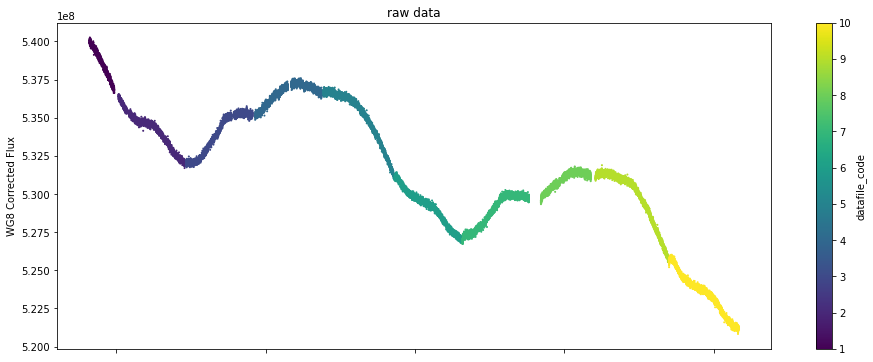

In [3]:
df.plot.scatter(x='Time (days)', y='WG8 Corrected Flux', c='datafile_code', s=1,
                colormap='viridis', title="raw data", figsize=(16, 6))
plt.show()

#### Smoothed Observation Data

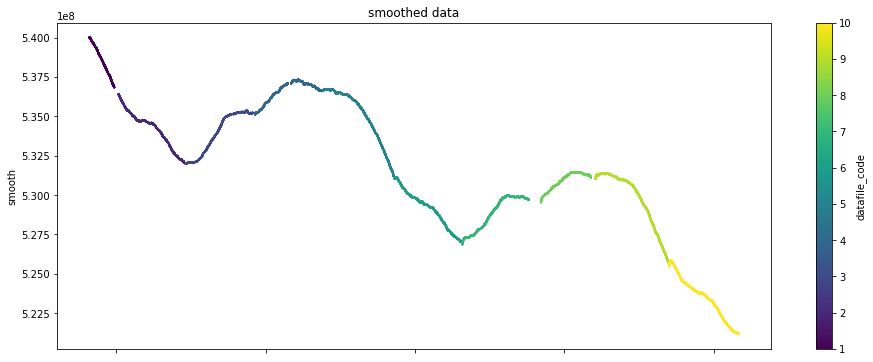

In [4]:

df.plot.scatter(x='Time (days)', y='smooth', c='datafile_code', s=1,
                colormap='viridis', title="smoothed data", figsize=(16, 6))
plt.show()
# plt.savefig("../img/raw_data.png")
# plt.close()

## remove 4sigma outliers and divide by 5-days mean

sigma is given by the columne *WG8 Corrected error*

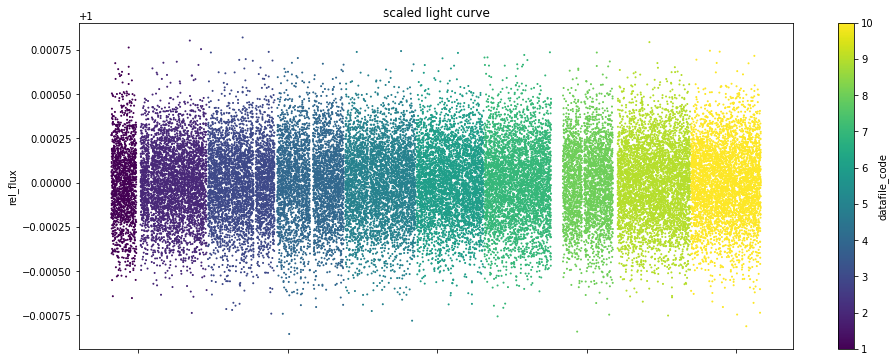

In [5]:

def calc_outliers_and_mean(all_data):

    all_data = all_data.sort_values('Time (days)')
    all_data['rel_flux'] = all_data['WG8 Corrected Flux'] / all_data['smooth']
    df = all_data[np.abs(all_data['rel_flux'] - all_data['rel_flux'].mean()) < 4*all_data['rel_flux'].std()]

    return df

if not os.path.exists("astero_means.pkl"):
    df = calc_outliers_and_mean(df)
    df.to_pickle("astero_means.pkl")
else:
    df = pd.read_pickle("astero_means.pkl")

    
df.plot.scatter(x='Time (days)', y="rel_flux", s=1,
                c='datafile_code', colormap='viridis', title="scaled light curve", figsize=(16, 6))
plt.show()
# plt.savefig("../img/corrected.png")
# plt.close()

## Fourier Transform null-meaned flux data

Apply Fourier Transform on the smoothed dataset, using the `dfourier` function.
The input values must be null-meaned. The spectrum should be calculated within the frequency limits of 0 to 20 (unit: $ [\frac{1}{day}]$) with an oversampling of 1.

The function `dfunction` returns the frequencies and amplitudes of the spectrum.

Example: `freq, amp = dfourier(time, flux, [0,20], 1)`

In [6]:
def dfourier(t, y, frange, os):
    df = 1 / ((np.max(t) - np.min(t)) * os)
    loops = int((frange[1] - frange[0]) / df)

    f = np.arange(loops) * df + frange[0]
    re = np.zeros(loops)
    im = np.zeros(loops)

    for i in range(loops):
        arg = f[i] * t * 2 * np.pi
        im[i] = np.sum(y * np.sin(arg))
        re[i] = np.sum(y * np.cos(arg))

    a = 2 / len(t) * np.sqrt(re ** 2 + im ** 2)

    return f, a

In [7]:
timesteps = df['Time (days)'].values
signal = df['rel_flux'] - df['rel_flux'].mean()
start_time = timesteps[0]
end_time = timesteps[-1]  # * 3600 * 24  # in seconds
n_timesteps = len(timesteps)
average_timestep = (end_time - start_time) / n_timesteps
average_freq = 1. / average_timestep


#### Nyquist Frequency
The Nyquist frequency is half of the sampling rate of a discrete signal.

$f_{Nyq} = \frac{1}{2 \Delta t}$

Unit: $\frac{1}{day}$

In [8]:
nyquist = average_freq / 2.
print(nyquist)

22.220708821940352


In [9]:

if not os.path.exists(f"amplitude_window_{MAX_DAYS_FREQ}_days.pkl"):
    freq, amp_window = dfourier(timesteps, signal, [-MAX_DAYS_FREQ, MAX_DAYS_FREQ], 1)
    freq_muHz = freq * PER_DAY_TO_PER_muHZ
    df = pd.DataFrame({'freq': freq_muHz, 'amp': amp_window})
    df.to_pickle(f"amplitude_window_{MAX_DAYS_FREQ}_days.pkl")
else:
    df = pd.read_pickle(f"amplitude_window_{MAX_DAYS_FREQ}_days.pkl")
    freq_muHz = df.freq.values
    freq = freq_muHz / PER_DAY_TO_PER_muHZ
    amp_window = df.amp.values

#### Amplitude Spectrum
Units:
- $\frac{cycles}{day} = \frac{c}{d}$
- ppm = part per million

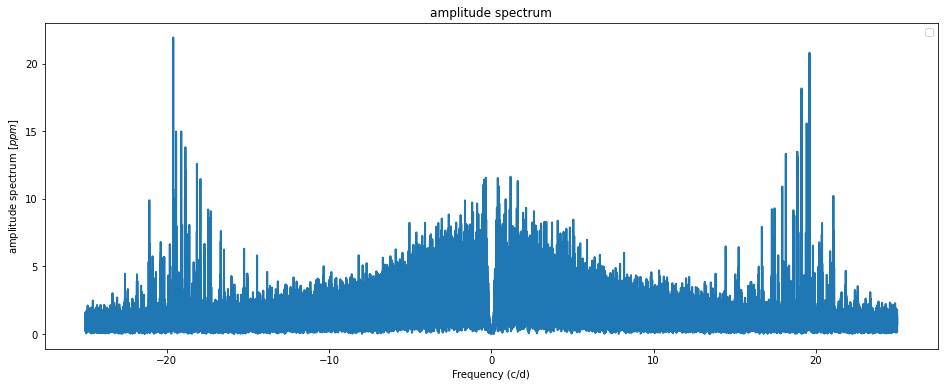

In [10]:

fig = plt.figure(figsize=FIGSIZE)
plt.legend('amplitude spectrum')
plt.ylabel('amplitude spectrum $[ppm]$')
plt.xlabel('Frequency (c/d)')
plt.title('amplitude spectrum')
plt.plot(freq, amp_window*1e6, linewidth=2)


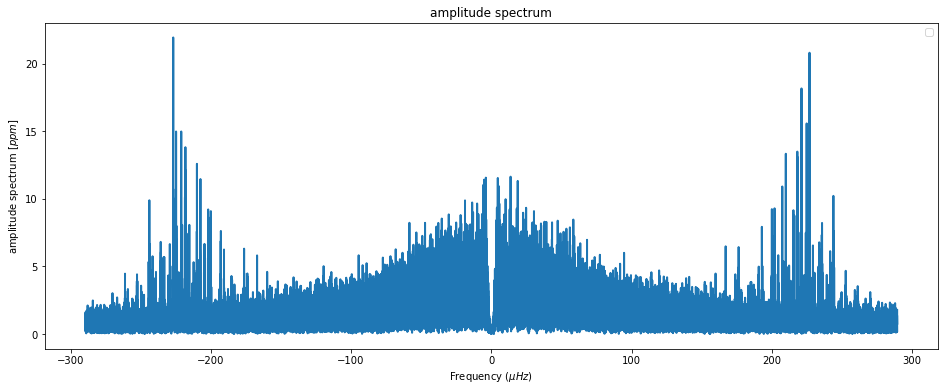

In [11]:

fig = plt.figure(figsize=FIGSIZE)
plt.legend('amplitude spectrum')
plt.ylabel('amplitude spectrum $[ppm]$')
plt.xlabel('Frequency ($\mu Hz$)')
plt.title('amplitude spectrum')
plt.plot(freq_muHz, amp_window*1e6, linewidth=2)
plt.show()
# plt.savefig("../img/fft-signal-amplitudes.png")
# plt.close()

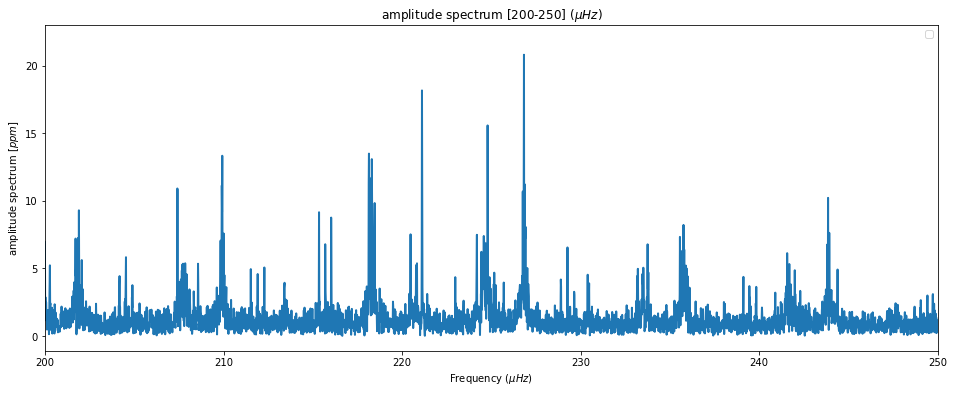

In [12]:

fig = plt.figure(figsize=FIGSIZE)
plt.legend('amplitude spectrum')
plt.ylabel('amplitude spectrum $[ppm]$')
plt.xlim([200, 250])
plt.xlabel('Frequency ($\mu Hz$)')
plt.title('amplitude spectrum [200-250] ($\mu Hz$)')
plt.plot(freq_muHz, amp_window*1e6, linewidth=2)


## Power Window

For the Spectral Window, all singla values are replaced by $1$.

! Important: These values are constant and not null-meaned

In [13]:
if not os.path.exists(f"spectral_window_{MAX_DAYS_FREQ}_days.pkl"):
    freq, amp_power_window = dfourier(timesteps, [1 for x in range(len(timesteps))], [-MAX_DAYS_FREQ, MAX_DAYS_FREQ], 1)
    freq_muHz = freq * PER_DAY_TO_PER_muHZ
    df = pd.DataFrame({'freq': freq_muHz, 'amp': amp_power_window})
    df.to_pickle(f"spectral_window_{MAX_DAYS_FREQ}_days.pkl")
else:
    df = pd.read_pickle(f"spectral_window_{MAX_DAYS_FREQ}_days.pkl")
    freq_muHz = df.freq.values
    freq = freq_muHz / PER_DAY_TO_PER_muHZ
    amp_power_window = df.amp.values


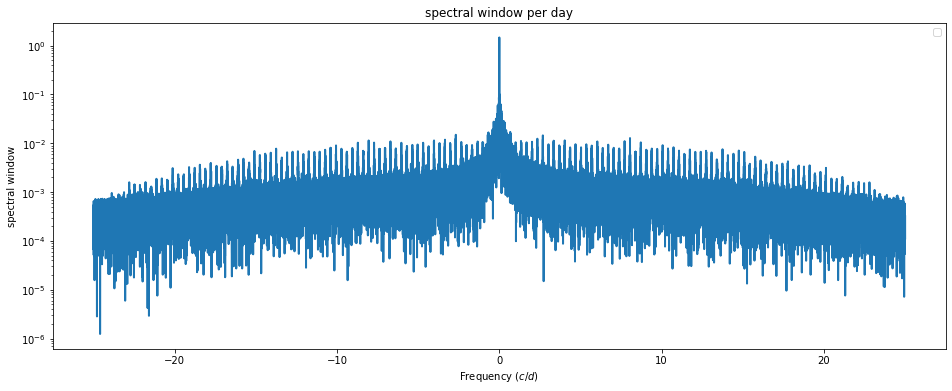

In [14]:

fig = plt.figure(figsize=FIGSIZE)
plt.legend('spectral window')
plt.ylabel('spectral window')
plt.xlabel('Frequency $(c/d)$')
plt.title('spectral window per day')
plt.yscale('log')
plt.plot(freq, amp_power_window, linewidth=2)


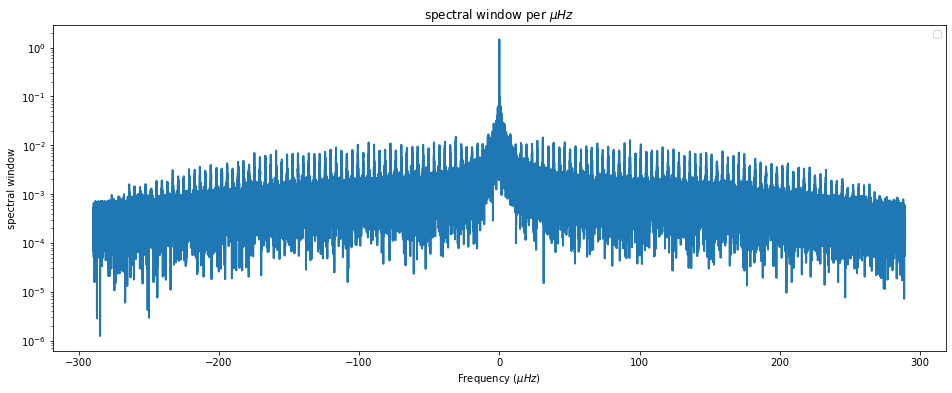

In [15]:
    
fig = plt.figure(figsize=FIGSIZE)
plt.legend('spectral window')
plt.ylabel('spectral window')
plt.xlabel('Frequency ($\mu Hz$)')
plt.title('spectral window per $\mu Hz$')
plt.yscale('log')
plt.plot(freq_muHz, amp_power_window, linewidth=2)
plt.show()

## Power Density Spectrum

$PDS (f) = \frac{AMP (f)^2}{\int_{-f_{Nyq}}^{+f_{Nyq}} SPW(f) df}$

The power density spectrum is used to determine the osciallation of the star.

In [16]:
# restrict frequencies for integration to between nyquist

f_ny_days = average_freq  / 2
f_ny_muHz = f_ny_days * PER_DAY_TO_PER_muHZ

if not os.path.exists(f"pds_{MAX_DAYS_FREQ}_days.pkl"):
    # 1e12 for time conversion
    # 1e6 for conversion to ppm
    pds = amp_window * amp_window / np.sum(2  * f_ny_muHz * amp_power_window) * (1e12) * (1e6)
    df = pd.DataFrame({'freq': freq_muHz, 'pds': pds})
    df.to_pickle(f"pds_{MAX_DAYS_FREQ}_days.pkl")
else:
    df = pd.read_pickle(f"pds_{MAX_DAYS_FREQ}_days.pkl")
    freq_muHz = df.freq.values
    pds = df.pds.values

#### PDS, plot
- x: 0-350 $\mu Hz$

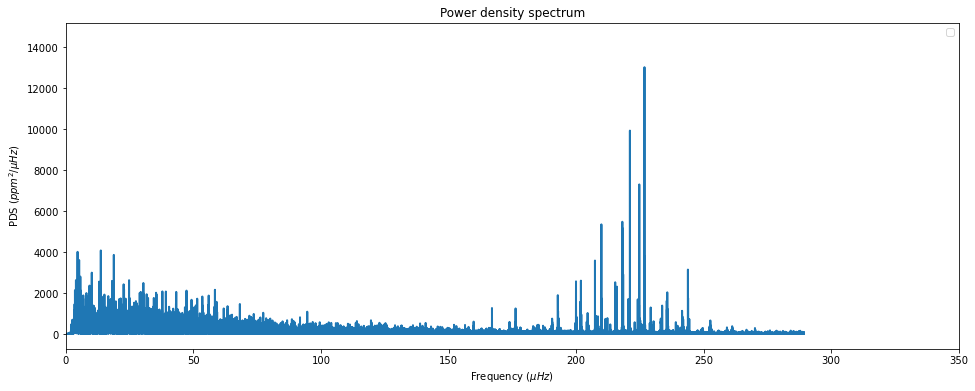

In [17]:


fig = plt.figure(figsize=FIGSIZE)
plt.legend('PDS ($ppm^2 / \mu Hz$)')
plt.ylabel('PDS ($ppm^2 / \mu Hz$)')
plt.xlabel('Frequency ($ \mu Hz$)')
plt.title('Power density spectrum')
plt.xlim([0, 350])
plt.plot(freq_muHz, pds, linewidth=2)
plt.show()


#### PDS, log-log plot
- x: 2-350 $\mu Hz$
- y: 1-12500 $ppm^2 / \mu Hz$

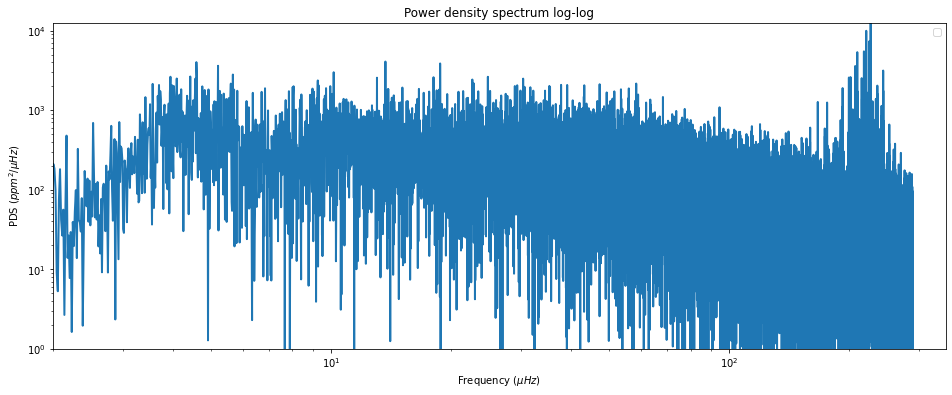

In [18]:


fig = plt.figure(figsize=FIGSIZE)
plt.legend('PDS ($ppm^2 / \mu Hz$)')
plt.ylabel('PDS ($ppm^2 / \mu Hz$)')
plt.xlabel('Frequency ($ \mu Hz$)')
plt.title('Power density spectrum log-log')
plt.yscale('log')
plt.xscale('log')
plt.xlim([2, 350])
plt.ylim([1, 12500])
plt.plot(freq_muHz, pds, linewidth=2)
plt.show()

## Daten Fit

Fit of data with Lorentzian Profile. The fit has 3 parts:

- Constant $P_g$
- Gauß-profile multiplied with $P_g$
- 2 Lorentz-Profiles (if we sum $i$ with $i=0$ and $i=1$

$
P(\nu) = 
P_n + 
P_g \cdot exp(\frac{-(\nu_{max}-\nu)^2)}{(2 \sigma_g^2)} + 
\sum_i \frac{\zeta \cdot (a_i)^2)/b_i}{1+(\nu/b_i)^4}
$

with 

$\zeta = 2 \sqrt{2} / \pi$


In [19]:
averaging_window = 300

def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

# take only positive half of the frequencies and the corresponding pds values
pos_freqs = freq_muHz[len(freq_muHz)//2:]
pos_pds = pds[len(pds)//2:]

avg_freqs = pos_freqs[averaging_window-1:]  # freq with first values cut, because they miss in the amplitude rolling mean
avg_pds = moving_average(pos_pds, averaging_window)

z = 2 * math.sqrt(2) / math.pi

def model_function(x, P_n, P_g, nu_max, sigma, a_1, b_1, a_2, b_2):
    return P_n + P_g*np.exp(-((x-nu_max)**2)/(2*sigma**2))+ ((z*(a_1)**2)/b_1)/(1+(x/b_1)**4) + ((z*(a_2)**2)/b_2)/(1+(x/b_2)**4)


### Fit with scipy curve_fit

In [20]:
# fit using scipy
# initial guess of: 
parameter_names = ["P_n", "P_g", "nu_max", "sigma", "a_1", "b_1", "a_2", "b_2"]
initial_guess = [
    15.22,
    124.8,
    220,
    14.1,
    154.6,
    60.97,
    118.4,
    203.2
]
popt, pcov = curve_fit(model_function, avg_freqs, avg_pds, p0=initial_guess)
y_fit = model_function(avg_freqs, *popt)

#### plot scipy fit of curve

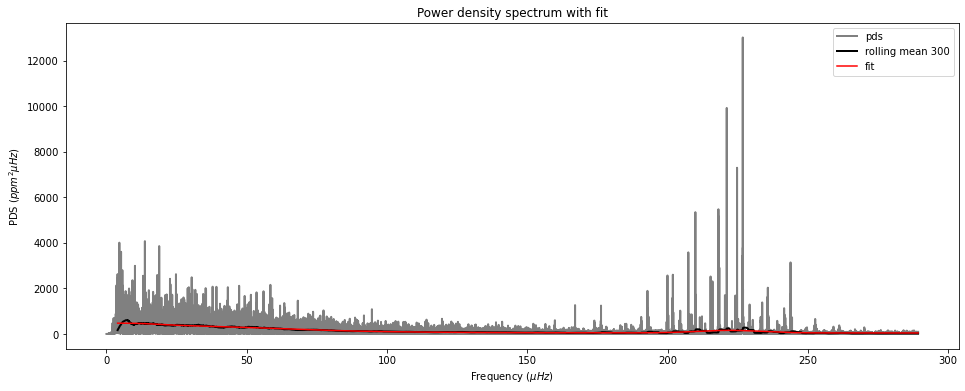

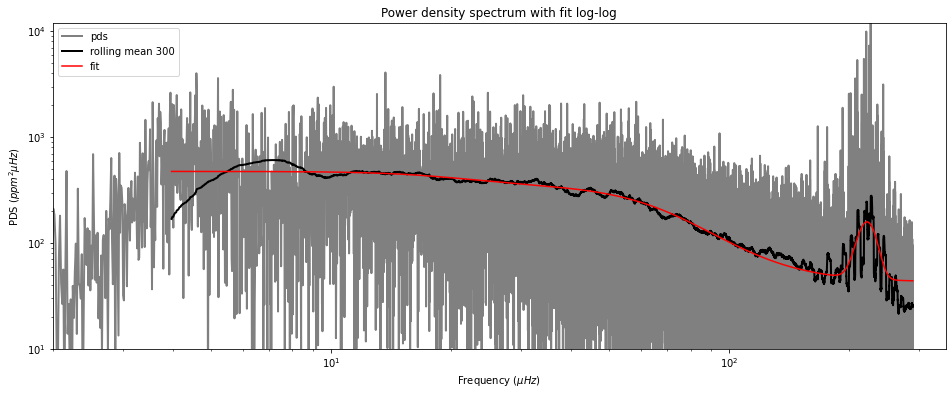

Fit Results
('P_n', 42.98536938168717)
('P_g', 112.64373333784984)
('nu_max', 222.147440723852)
('sigma', 11.492942049689919)
('a_1', 54.17522859157014)
('b_1', 20.794312879191168)
('a_2', 153.92189185748566)
('b_2', 69.98976757372932)


In [21]:
#Plot-section
fig = plt.figure(figsize=FIGSIZE)
plt.legend('PDS ($ppm^2 \mu Hz$)')
plt.ylabel('PDS ($ppm^2 \mu Hz$)')
plt.xlabel('Frequency ($ \mu Hz$)')
plt.title('Power density spectrum with fit')
plt.plot(pos_freqs, pos_pds, linewidth=2, label='pds', color='gray')
plt.plot(avg_freqs, avg_pds, linewidth=2, label=f'rolling mean {averaging_window}', color='black')
plt.plot(avg_freqs, y_fit, label='fit', color='red')
plt.legend()
plt.show()

#Plot-section log
fig = plt.figure(figsize=FIGSIZE)
plt.legend('PDS ($ppm^2 \mu Hz$)')
plt.ylabel('PDS ($ppm^2 \mu Hz$)')
plt.xlabel('Frequency ($ \mu Hz$)')
plt.title('Power density spectrum with fit log-log')
plt.xlim([2, 350])
plt.ylim([10, 12000])
plt.yscale('log')
plt.xscale('log')
plt.plot(pos_freqs, pos_pds, linewidth=2, label='pds', color='gray')
plt.plot(avg_freqs, avg_pds, linewidth=2, label=f'rolling mean {averaging_window}', color='black')
plt.plot(avg_freqs, y_fit, label='fit', color='red')
plt.legend()
plt.show()

print("Fit Results")
for x in list(zip(parameter_names, popt)):
    print(x)

#### Comments

For comparison, the values given in the script were

- $P_n = 15.22$
- $P_g = 124.8$
- $\nu_{max} = 220$
- $\sigma = 14.1$
- $a_1 = 154.6$
- $b_1 = 60.97$
- $a_2 = 118.4$
- $b_2 = 203.2$


## READ MESA & GYRE OUTPUT


### Link

- Mesa-Docker: https://github.com/evbauer/MESA-Docker
- Gyre: https://bitbucket.org/rhdtownsend/gyre/wiki/Running%20GYRE



### MESA
- Install from git with as described in: https://github.com/evbauer/MESA-Docker

Install xming, and Docker. Copy files from the folder  
```
astero_mesa
``` 

into a directory under 
```bash
/home/docker/docker_work
```
E.g.
```bash
/home/docker/docker_work/mesa_dir
```

The directory in docker `/home/docker/docker_work` is mapped directory, so it can be accessed from the local file system.

Then run the `mk` and `rn` commands in the directory. To prepare mesa for the simulation.


#### settings

Settings are to be done on the files
```
inlist
inlist_pgstar
inlist_project
```
##### initial_mass
initial mass in Msun units. can be any value you’d like when you are creating a pre-main sequence model.

NOTE: this is not used when loading a saved model. however is reported in output as the initial mass of the star. don’t let that confuse you.

if you are loading a ZAMS model and the requested mass is in the range of prebuilt models, the code will interpolate in mass using the closest prebuilt models. if the requested mass is beyond the range of the prebuilt models, the code will load the closest one and then call “relax mass” to create a model to match the request. the prebuilt range is 0.08 Msun to 100 Msun, so the relax_mass method is only used for extreme cases. there are enough prebuilt models that the interpolation in mass seems to work fine for many applications.

`initial_mass = 1`

##### initial_z
initial metallicity for create pre-ms and create initial model initial_z can be any value from 0 to 0.04

not used when loading a saved model. however is reported in output as the initial Z of the star.

however, if you are loading a zams model, then initial_z must match one of the prebuilt values. look in the 'data/star_data/zams_models' directory to see what prebuilt zams Z’s are available. at time of writing, only 0.02 was included in the standard version of star.
`initial_z = 0.02d0`

##### initial_y
initial helium mass fraction for create pre-ms and create initial (< 0 means use default which is `0.24 + 2*initial_z`)

not used when loading a saved model or a zams model. however is reported in output as the initial Y of the star.

NOTE: this is only used for create pre-main-sequence model and create initial model, and not when loading a zams model.

##### mixing_length_alpha
The mixing length is this parameter times a local pressure scale height. To increase R vs. L, decrease mixing_length_alpha.


##### star model for input file to be run

the source for the star model: https://iopscience.iop.org/article/10.3847/0004-637X/817/1/65#apj521935s5

More info: https://arxiv.org/abs/1511.06160

- mass: `1.02 Msun`
- metallicity: `0.022`
- helium content: `default value`
- mixing length: `1.8`




#### inlist
```

&star_job

      read_extra_star_job_inlist1 = .true.
      extra_star_job_inlist1_name = 'inlist_project'

/ ! end of star_job namelist



&controls

      read_extra_controls_inlist1 = .true.
      extra_controls_inlist1_name = 'inlist_project'

/ ! end of controls namelist



&pgstar

      read_extra_pgstar_inlist1 = .true.
      extra_pgstar_inlist1_name = 'inlist_pgstar'

/ ! end of pgstar namelist

```

#### inlist_pgstar
```
&pgstar

  ! MESA uses PGPLOT for live plotting and gives the user a tremendous
  ! amount of control of the presentation of the information.

  ! show HR diagram
  ! this plots the history of L,Teff over many timesteps
    HR_win_flag = .true.

  ! set static plot bounds
    HR_logT_min = 0.1
    HR_logT_max = 5.0
    HR_logL_min = 0.1
    HR_logL_max = 2.0

  ! set window size (aspect_ratio = height/width)
    HR_win_width = 9
    HR_win_aspect_ratio = 1.0


  ! show temperature/density profile
  ! this plots the internal structure at single timestep
    TRho_Profile_win_flag = .true.

  ! add legend explaining colors
    show_TRho_Profile_legend = .true.

  ! display numerical info about the star
    show_TRho_Profile_text_info = .true.

  ! set window size (aspect_ratio = height/width)
    TRho_Profile_win_width = 10
    TRho_Profile_win_aspect_ratio = 0.75

/ ! end of pgstar namelist

```

#### inlist_project

```
! inlist to evolve a 15 solar mass star

! For the sake of future readers of this file (yourself included),
! ONLY include the controls you are actually using.  DO NOT include
! all of the other controls that simply have their default values.

&star_job

  ! begin with a pre-main sequence model
  ! original:
  !  create_pre_main_sequence_model = .true.
  ! aster course input:
    show_log_description_at_start = .false.
    create_pre_main_sequence_model = .false.

  ! course parameters:
    kappa_file_prefix = 'gs98'

    change_initial_net = .true.      
    new_net_name = 'o18_and_ne22.net'

    pre_ms_relax_num_steps = 50

  ! save a model at the end of the run
    save_model_when_terminate = .false.
    save_model_filename = '15M_at_TAMS.mod'

  ! display on-screen plots
    pgstar_flag = .true.


/ !end of star_job namelist


&controls

  ! starting specifications
  ! initial_mass = 15 ! in Msun units

    max_model_number = 20000
    max_num_profile_models = 20000

    initial_mass = 1.02  ! sun masses, based on KIC 4448777
    initial_z = 0.02  ! metallicity, based on KIC 4448777
    initial_y = -1    !

    mixing_length_alpha = 1.8 ! based on KIC 4448777

    photo_interval = 5000
    profile_interval = 1
    history_interval = 1
    terminal_interval = 10
    write_header_frequency = 10

    log_g_lower_limit = 3.00

  ! Pulsation output
      pulse_data_format = 'GYRE'
    write_pulse_data_with_profile = .true.

  ! options for energy conservation (see MESA V, Section 3)
     use_dedt_form_of_energy_eqn = .true.
     use_gold_tolerances = .true.

  ! stop when the star nears ZAMS (Lnuc/L > 0.99)
    Lnuc_div_L_zams_limit = 0.999d0
  !  stop_near_zams = .true.

  ! stop when the center mass fraction of h1 drops below this limit
  !  xa_central_lower_limit_species(1) = 'h1'
  !  xa_central_lower_limit(1) = 1d-9

/ ! end of controls namelist

```


#### MESA Output

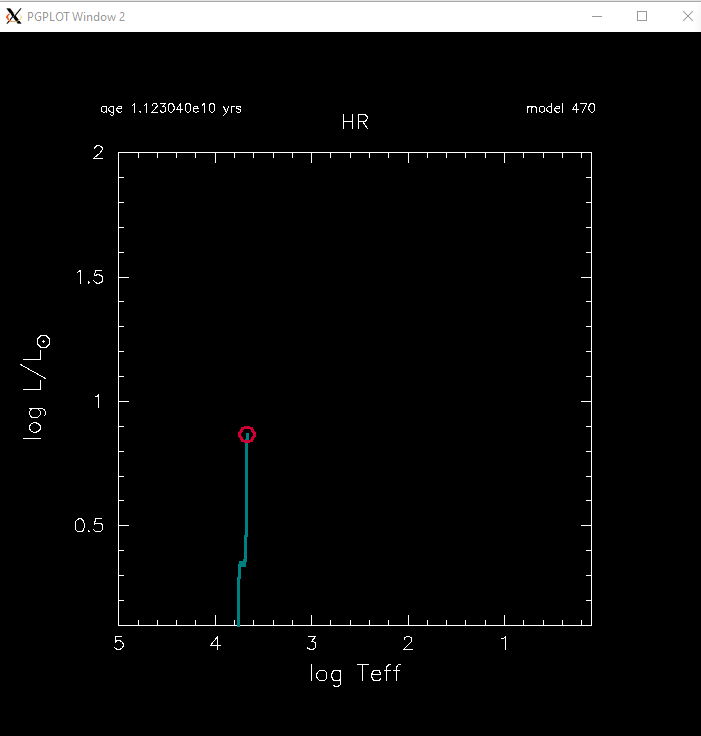

In [22]:
Image(filename='../mesa-output.png') 

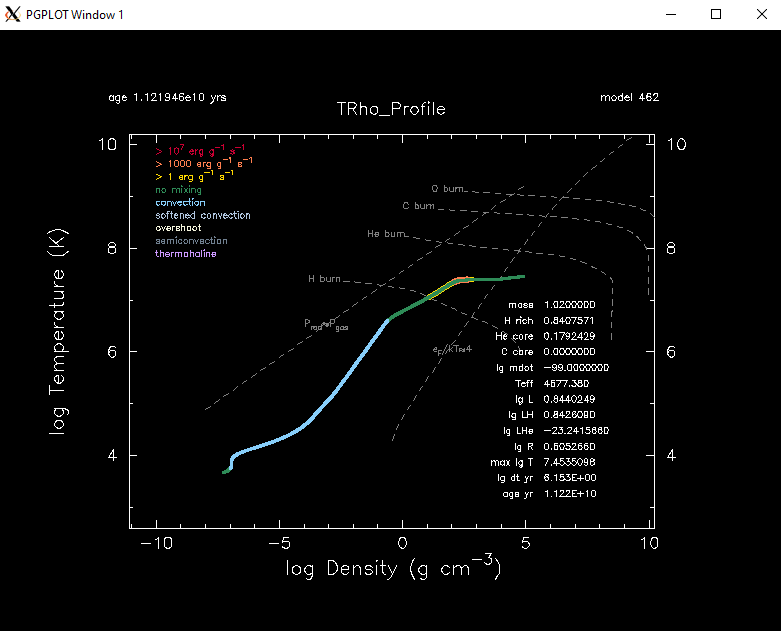

In [23]:
Image(filename='../mesa-hr-output.png') 

### GYRE

#### prepare

- in the docker, you can find gyre at: `/home/docker/mesa/gyre`
- make gyre: `~/mesa/gyre/gyre$ make`
- set GYRE_DIR environment variable `export GYRE_DIR=/home/docker/mesa/gyre/gyre/bin`

- check version: `/home/docker/mesa/gyre/gyre/bin/gyre --version`
```gyre [5.2] ```

- make folder for gyre project, which is in a mapped volume
```
/home/docker/docker_work/gyre_work
```

- move your gyre.in to your folder

- configure the created output profile in gyre.in

- Start gyre with input file: run in terminal:
```bash
/home/docker/mesa/gyre/gyre/bin/gyre gyre.in
```

- setting frequency units:

Since this is Gyre 5.2, follow the 5.2 documentation for input files on https://bitbucket.org/rhdtownsend/gyre/wiki/Namelist%20Input%20Files%20(5.2)

- to set `UHZ` frequency units: 

    - in `&scan` set:
`freq_min_units`
`freq_max_units`

    - in `&ad_output` set:
`freq_units` 

#### gyre.in
```
&constants
/

&model
	model_type = 'EVOL'  ! Obtain stellar structure from an evolutionary model
	file = 'profile453.data.GYRE'    ! File name of the evolutionary model
	file_format = 'MESA' ! File format of the evolutionary model
/

&mode
        l = 0                           ! Harmonic degree
        tag = 'radial' ! Tag for namelist matching
/

&osc
	outer_bound = 'JCD'
	!variables_set = 'JCD'
	inertia_norm = 'BOTH'
    tag_list = 'radial,non-radial' ! Comma-separated list of tags to match

	nonadiabatic = .false.
/

&num
	diff_scheme = 'MAGNUS_GL6' !sixth-order Gauss-Legendre Magnus solver
/

&scan
        grid_type = 'LINEAR' ! Scan for modes using a uniform-in-period grid; best for g modes
        freq_min = 0.2        ! Minimum frequency to scan from
	    freq_max = 1        ! Maximum frequency to scan to
        freq_min_units = 'ACOUSTIC_CUTOFF'   ! Interpret freq_min and freq_max as being dimensionless
        freq_max_units = 'ACOUSTIC_CUTOFF'   ! Interpret freq_min and freq_max as being dimensionless
		n_freq = 200          ! Number of frequency points in scan
        tag_list = 'radial'  ! Comma-separated list of tags to match
/

&grid
	alpha_osc = 10  ! Ensure at least 10 points per wavelength in propagation regions
	alpha_exp = 2   ! Ensure at least 2 points per scale length in evanescent regions
	n_inner = 5     ! Ensure at least 5 points between center and inner turning point
/

&shoot_grid
        op_type = 'RESAMP_DISPERSION'
        alpha_osc = 5
        alpha_exp = 1
/

&shoot_grid
        op_type = 'RESAMP_CENTER'
        n = 5
/

&recon_grid
        op_type = 'CREATE_CLONE'
/

&ad_output
    summary_file = 'summary.txt'                            			! File name for summary file
	summary_file_format = 'TXT'                             			! Format of summary file
    summary_item_list = 'M_star,R_star,L_star,l,n_p,n_g,freq,E_norm,W' ! Items to appear in summary file
	freq_units='UHZ'
/
&nad_output
/


```

### Prepare functions to read the gyre summary output
we move the output file of gyre to the project and rename the summary.
The summary will be read out such that Python can plot it.

In [24]:
def open_gyre_files(summary_file_path):
    with open(summary_file_path) as f:
        lines = f.readlines()
   
    star_property_lines = []
    for line in lines[2:4]:
        star_property_lines.append([x.strip("\n") for x in line.split(" ") if x])
    
    datalines = lines[5:]
    stripped_lines = [[e for e in l.strip("\n").split(" ") if e] for l in datalines]
    header = stripped_lines[0]
    stripped_lines = stripped_lines[1:]
    return dict(list(zip(*star_property_lines))), header, stripped_lines

def get_re_freq(header, stripped_lines):
    idx = None
    for idx, h in enumerate(header):
        if h=="Re(freq)":
            break
    freq_values = [float(l[idx]) for l in stripped_lines]
    return freq_values
    

### read files and plot echelle

In [25]:
def plot_echelle_with_manual(summary_file_path, model, manual_frequencies):
    star_properties, header, stripped_lines = open_gyre_files(summary_file_path)

    M_SUN = 1.9884e33  # g
    R_SUN = 6.96342e10  # cm
    L_SUN = 3.846e33  # erg/s

    m = float(star_properties.get("M_star", 0))/M_SUN
    r = float(star_properties.get("R_star", 0))/R_SUN
    l = float(star_properties.get("L_star", 0))/L_SUN

    print("MODEL {} COMPARED TO SUN: ".format(model))
    print(round(m, 2), "Mass (Sun)")
    print(round(r, 2), "Radius (Sun)")
    print(round(l, 2), "Luminosity (Sun)")
    print("")
    
    # values found by star evolution simulation
    MODULO = 17

    freq_values = get_re_freq(header, stripped_lines)
    
    x=[i%MODULO for i in freq_values]
    plt.scatter(x,freq_values, label="MESA-GYRE")

    # manually found values
    freq_values_manual = manual_frequencies
    x=[i%MODULO for i in freq_values_manual]
    plt.scatter(x,freq_values_manual, label="Manual")

    plt.grid()
    plt.legend()
    plt.ylabel('Frequency $\mu Hz$')
    plt.xlabel('Frequency module {} $\mu Hz$'.format(MODULO))
    plt.title('Echelle Diagramme - MESA Model {}'.format(model))
    plt.show()

#### Modulo 17, MESA Model 433 - 483

MODEL 433 COMPARED TO SUN: 
1.02 Mass (Sun)
3.6 Radius (Sun)
5.7 Luminosity (Sun)



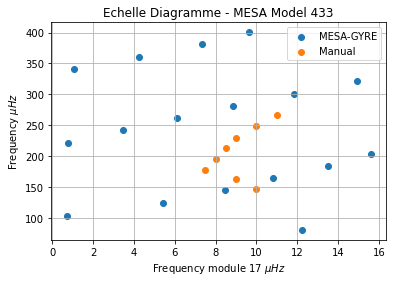

MODEL 443 COMPARED TO SUN: 
1.02 Mass (Sun)
3.75 Radius (Sun)
6.13 Luminosity (Sun)



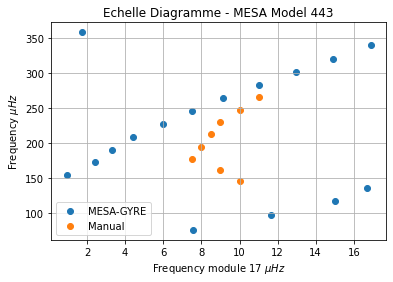

MODEL 453 COMPARED TO SUN: 
1.02 Mass (Sun)
3.89 Radius (Sun)
6.57 Luminosity (Sun)



MODEL 460 COMPARED TO SUN: 
1.02 Mass (Sun)
4.0 Radius (Sun)
6.89 Luminosity (Sun)



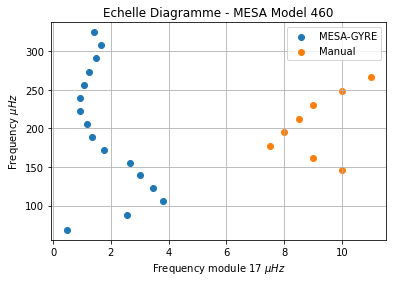

MODEL 463 COMPARED TO SUN: 
1.02 Mass (Sun)
4.04 Radius (Sun)
7.02 Luminosity (Sun)



MODEL 473 COMPARED TO SUN: 
1.02 Mass (Sun)
4.19 Radius (Sun)
7.49 Luminosity (Sun)



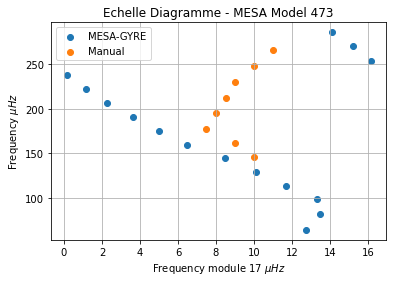

MODEL 483 COMPARED TO SUN: 
1.02 Mass (Sun)
4.35 Radius (Sun)
7.99 Luminosity (Sun)



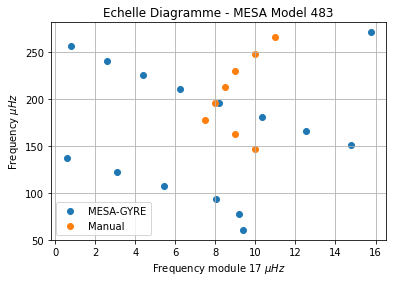

In [26]:
# Model 433 results better manual reading

plot_echelle_with_manual(summary_file_path='../gyre_output/summary_433.txt', 
                         model=433, 
                         manual_frequencies=[146, 162, 177.5, 195, 212.5, 230, 248, 266])

# Model 443 results better manual reading

plot_echelle_with_manual(summary_file_path='../gyre_output/summary_443.txt', 
                         model=443, 
                         manual_frequencies=[146, 162, 177.5, 195, 212.5, 230, 248, 266])

# Model 453 results better manual reading

plot_echelle_with_manual(summary_file_path='../gyre_output/summary_453.txt', 
                         model=453, 
                         manual_frequencies=[146, 162, 177.5, 195, 212.5, 230, 248, 266])

# Model 460 results better manual reading

plot_echelle_with_manual(summary_file_path='../gyre_output/summary_460.txt', 
                         model=460, 
                         manual_frequencies=[146, 162, 177.5, 195, 212.5, 230, 248, 266])

# Model 463 results better manual reading

plot_echelle_with_manual(summary_file_path='../gyre_output/summary_463.txt', 
                         model=463, 
                         manual_frequencies=[146, 162, 177.5, 195, 212.5, 230, 248, 266])

# Model 473 results better manual reading

plot_echelle_with_manual(summary_file_path='../gyre_output/summary_473.txt', 
                         model=473, 
                         manual_frequencies=[146, 162, 177.5, 195, 212.5, 230, 248, 266])

# Model 483 results better manual reading

plot_echelle_with_manual(summary_file_path='../gyre_output/summary_483.txt', 
                         model=483, 
                         manual_frequencies=[146, 162, 177.5, 195, 212.5, 230, 248, 266])